In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import geoplot
import shapely
import pysal


/home/ja/miniconda3/envs/map/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Create some random XY points between 0 and 100 in each dimension, and plot for fun

In [3]:
total_points = 10000
xy = 1.2 * np.random.rand(total_points,2)
xydf = pd.DataFrame(data=xy)
xydf.columns = ['x', 'y']

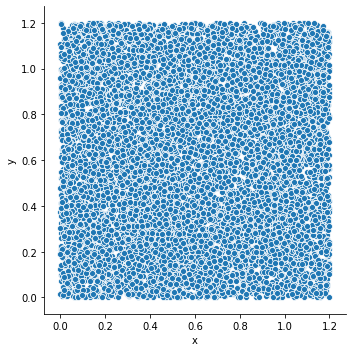

In [4]:
#xydf
sns.relplot(x="x", y="y", data=xydf);

Generate a spatial weights matrix for the points based on $k$ nearest neighbours

In [7]:
# weights matrix for k nearest
kd = pysal.lib.cg.kdtree.KDTree(xy)
W = pysal.lib.weights.KNN(kd, 20)
W.transform = 'r' # row normalizing

In [8]:
# to an array
W = (W.sparse)
W = (W.toarray())

generate random errors (standard normal) and an identity matrix

In [10]:
errors_ind = np.random.normal(0, 1, total_points)
#print(errors_ind)
xydf["errors"] = errors_ind
I = np.identity(total_points)


In [11]:
rho = 0.6

$Y = (I - \rho W)^{-1} \epsilon$

In [12]:
%%time
Y = np.matrix(I - rho * W).I.dot(errors_ind)

# 10k points = 83 seconds

CPU times: user 1min 5s, sys: 1.97 s, total: 1min 7s
Wall time: 30.1 s


In [13]:
xydf["sim"] = np.transpose(Y)


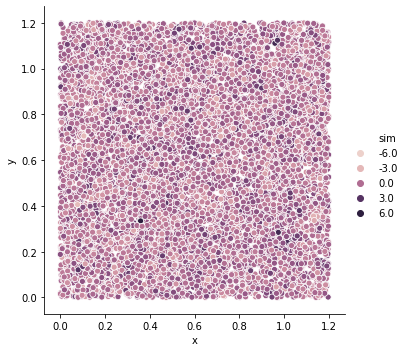

In [14]:
sns.relplot(x="x", y="y", hue="sim",data=xydf);
# sns.relplot(x="x", y="y", hue="errors",data=xydf); # plot errors if we want

In [15]:
simmean = xydf["sim"].mean()
xydf['sim_b'] = 0
xydf['sim_b'][xydf['sim'] > simmean] = 1
xydf.head(12)

/home/ja/miniconda3/envs/map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,x,y,errors,sim,sim_b
0,0.251470,0.491074,-0.098863,-0.020249,0
1,0.230863,0.055491,1.636584,1.528187,1
2,0.400073,0.631270,-1.427450,-1.481002,0
3,0.792084,0.926815,1.829129,2.113667,1
4,0.296161,0.235586,-1.003064,-1.341934,0
5,1.025596,0.503022,1.373701,1.514868,1
6,0.062394,0.208530,0.555712,0.536680,1
7,1.150808,0.353862,0.350771,-0.229512,0
8,0.454976,0.707071,-0.710226,-0.508225,0
9,0.293055,1.146041,0.658985,0.642930,1


In [16]:
# add in binomial distribution for whether observation is sampled, for several sampling rates [0.03,0.05,0.1,0.2,0.5,1.0]
xydf["sample_03"] = np.random.binomial(1, 0.03, size=total_points)
xydf["sample_05"] = np.random.binomial(1, 0.05, size=total_points)
xydf["sample_10"] = np.random.binomial(1, 0.10, size=total_points)
xydf["sample_20"] = np.random.binomial(1, 0.20, size=total_points)
xydf["sample_50"] = np.random.binomial(1, 0.50, size=total_points)
xydf["sample_100"] = np.random.binomial(1, 1, size=total_points)
xydf.head(8)

,x,y,errors,sim,sim_b,sample_03,sample_05,sample_10,sample_20,sample_50,sample_100
0,0.251470,0.491074,-0.098863,-0.020249,0,0,0,0,0,0,1
1,0.230863,0.055491,1.636584,1.528187,1,0,0,0,0,1,1
2,0.400073,0.631270,-1.427450,-1.481002,0,0,0,0,0,1,1
3,0.792084,0.926815,1.829129,2.113667,1,0,0,0,1,1,1
4,0.296161,0.235586,-1.003064,-1.341934,0,0,0,0,0,1,1
5,1.025596,0.503022,1.373701,1.514868,1,0,0,1,0,0,1
6,0.062394,0.208530,0.555712,0.536680,1,0,0,0,0,0,1
7,1.150808,0.353862,0.350771,-0.229512,0,0,0,1,0,1,1


In [14]:
# convert to geopandas layer
geometry = [shapely.geometry.Point(xy) for xy in zip(xydf.x, xydf.y)]
gdf = gpd.GeoDataFrame(xydf,  geometry=geometry)

In [15]:
# load in grid data
grid_12 = gpd.read_file("grids/grid_12x12.geojson")
# geoplot.polyplot(grid_12, figsize=(3, 4))

In [18]:
xy_with_grid = gpd.sjoin(gdf, grid_12, how="inner", op='intersects')



/home/ja/miniconda3/envs/map/lib/python3.7/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [ ]:
grid_12_desc = xy_with_grid.groupby(
   ['id']
).agg(
    {
         'errors': "count",
         'sim': "mean",  # get the count of networks
         'sim_b': "sum"  # get the first date per group
    }
)

In [21]:
grid_12_desc["mean"] = grid_12_desc["sim"]
grid_12_desc["prop"] = grid_12_desc["sim_b"] / grid_12_desc["errors"]
grid_12_desc["count"] = grid_12_desc["errors"]
grid_12_desc.head()

,errors,sim,sim_b,mean,prop,count
id,,,,,,
1,70,0.264381,47,0.264381,0.671429,70
2,72,-0.267062,30,-0.267062,0.416667,72
3,73,-0.106530,34,-0.106530,0.465753,73
4,68,0.062093,35,0.062093,0.514706,68
5,67,-0.280155,26,-0.280155,0.388060,67


In [ ]:
# join this data 

Compute global autocorrelation stats testing

In [65]:
# weights matrix for k nearest
xydf["null"] = np.random.normal(0, 1, total_points)
kd = pysal.lib.cg.kdtree.KDTree(xy)
W = pysal.lib.weights.KNN(kd, 5)
W.transform = 'r' # row normalizing
mi = pysal.explore.esda.Moran(np.array(xydf["errors"]), W, two_tailed=False)
Gi = pysal.explore.esda.G(np.array(xydf["errors"]), W)

In [66]:
print(mi.I, mi.p_norm,mi.p_rand)
print(Gi.G, Gi.p_norm)

-0.028200011718154037 0.18702598464558906 0.186978423961365
0.1443398725284427 0.18612401004643941


In [54]:
# pysal.spreg.ml_lag.ML_Lag(y = np.array(pd.Series(xydf["sim"])), x = np.array(pd.Series(xydf["errors"])), w = W)
# help(pysal.spreg.ml_lag.ML_Lag)
# mx = np.array(pd.Series(xydf["errors"]))
# my = np.array(pd.Series(xydf["sim"]))
# pysal.model.spreg.OLS(y = my, x = mx, w = W)
# np.array(pd.Series(xydf["sim"]))

YVar='sim'
XVars=['null']
# xydf[[YVar]+XVars].corr() 
Ym=xydf[YVar].values.reshape((len(xydf),1))
Xm=xydf[XVars].values
#ols= pysal.model.spreg.OLS(Ym,Xm,w=W,name_y=YVar, name_x=XVars,nonspat_diag=False, spat_diag=True)
#print(ols.summary)
mlag = pysal.model.spreg.ml_lag.ML_Lag(Ym,Xm,w=W,name_y=YVar, name_x=XVars)
mlag.rho

Exception: power expansion will not converge, check model specification and that weight are less than 1

Okay! what next

1000 iterations:

- generate random points
- compute spatial weights matrix of points (knn = 10) (or more on this?)
- generate spatial autoregressive to compute values
- also create a binary, based on +/- 0

for g in grid sizes
    - generate a grid (n grid sizes)
    - join points to grid - aggregate values
    - generate TRUE I, G, rho
    - Gi*, Ii, 

    for s in sample sizes
        - select points based on sample rate (n samples)
        - re-agg values to grid
        - generate estimated I, G, rho for
        - Gi*, Ii, 
